# NLP for Extraction of Phenotypes for Inherited Retinal Disease of EHR - BERT

Dataset: randomly sample 500 discharge summaries (DS) from MIMIC-III. <br>
Description of the dataset: https://mimic.mit.edu/docs/iii/tables/ <br>

## Importing additional Python libraries<a class="anchor" id="1"></a>
<!-- <mark>[Return Contents](#0) -->

In [1]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Activation, Dropout, GlobalMaxPool1D, Conv1D
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import text, sequence
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# import torch
# print(torch.__version__)
# import tensorflow
# print(tensorflow.__version__)
# import keras
# print(keras.__version__)

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

## Importing Dataset and preprocessing <a class="anchor" id="2"></a>
<!-- <mark>[Return Contents](#0) -->

In [5]:
path = ('....xlsx')
xl = pd.ExcelFile(path)
df = xl.parse('Sheet1')
# df.head()

In [99]:
df.shape

(1073, 14)

In [7]:
# print(df.columns.tolist()) # column names

In [8]:
# df.dtypes

In [6]:
# df['document structure'].value_counts()

### Data cleaning <a class="anchor" id="2_1"></a>

In [9]:
# df.isnull().any()

Class lable : `gold mention-to-UMLS label`: Check whether the matching is correct from the mention to the UMLS concept, 1 if correct, 0 if not.

In [104]:
df['gold mention-to-UMLS label'].value_counts() # 1 incorrect data for 'gold mention-to-UMLS label'

 0    743
 1    329
-1      1
Name: gold mention-to-UMLS label, dtype: int64

In [105]:
df.drop(df[df['gold mention-to-UMLS label'] == -1].index, inplace=True) # delete unexpected data

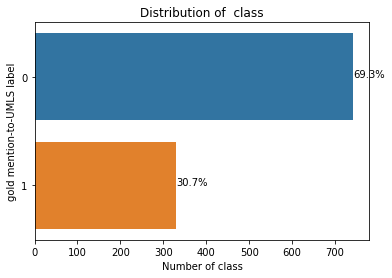

In [106]:
ax = sns.countplot(y="gold mention-to-UMLS label", data=df)
plt.title('Distribution of  class')
plt.xlabel('Number of class')
total = len(df['gold mention-to-UMLS label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
# plt.savefig('class_label')
plt.show()

## Generation of training and testing set<a class="anchor" id="6"></a>
<!-- <mark>[Return Contents](#0) -->

In [107]:
# df['classification']=""
# df['classification'] = df['gold mention-to-UMLS label'].map({1 : 'yes', 0 : 'no'})
# df.head()

In [108]:
texts = df['mention'].tolist()
labels = df['gold mention-to-UMLS label'].tolist()
X, X_test, y, y_test = train_test_split(texts,
                                        labels,
                                        test_size=0.2,
                                        train_size=0.8,
                                        random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X,
                                                  y,
                                                  test_size=0.25,
                                                  train_size=0.75,
                                                  random_state=seed)
# len(X_train), len(y_train), len(X_test), len(y_test), len(X_dev), len(y_dev)
print("Train size:", len(X_train))
print("Dev size:", len(X_dev))
print("Test size:", len(X_test))

Train size: 642
Dev size: 215
Test size: 215


## Classification algorithm 1: BERT<a class="anchor" id="7"></a>
<mark>[Return Contents](#0)

### Loading pre-trained models<a class="anchor" id="7_1"></a>
Model from huggingface: https://huggingface.co/models

In [109]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Loading data for training and testing<a class="anchor" id="7_1"></a>

In [110]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

### Define hyperparameters<a class="anchor" id="7_3"></a>

In [111]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

# #define a batch size
# batch_size = 5
# epochs = 75
# learning_rate = 1e-1

### Create a dataloader instance<a class="anchor" id="7_4"></a>

In [112]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

### Define BERT model<a class="anchor" id="7_5"></a>
- BERT pretrained model
- one feedforward layer

In [113]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert = bert 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

### Evaluation function<a class="anchor" id="7_6"></a>

In [114]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

### Training function<a class="anchor" id="7_6"></a>

In [115]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

### Identify CPU/GPU device for training<a class="anchor" id="7_8"></a>

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [118]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [119]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

### Train the model<a class="anchor" id="7_9"></a>

In [120]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 129/129 [00:04<00:00, 28.63it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 110.71it/s]


Training Loss: 0.365 dev performance, p:0.841, r:0.803, f1:0.822
current best score is 0.822

 Epoch 2 / 20



100%|██████████| 129/129 [00:04<00:00, 27.17it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 104.65it/s]


Training Loss: 0.303 dev performance, p:0.898, r:0.803, f1:0.848


current best score is 0.848

 Epoch 3 / 20


100%|██████████| 129/129 [00:05<00:00, 25.18it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.71it/s]


Training Loss: 0.207 dev performance, p:0.818, r:0.955, f1:0.881


current best score is 0.881

 Epoch 4 / 20


100%|██████████| 129/129 [00:05<00:00, 25.03it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.92it/s]


Training Loss: 0.269 dev performance, p:0.851, r:0.864, f1:0.857

 Epoch 5 / 20



100%|██████████| 129/129 [00:05<00:00, 25.22it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.71it/s]


Training Loss: 0.164 dev performance, p:0.831, r:0.970, f1:0.895


current best score is 0.895

 Epoch 6 / 20


100%|██████████| 129/129 [00:05<00:00, 25.52it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 104.97it/s]


Training Loss: 0.191 dev performance, p:0.829, r:0.955, f1:0.887

 Epoch 7 / 20



100%|██████████| 129/129 [00:05<00:00, 25.23it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.95it/s]


Training Loss: 0.133 dev performance, p:0.851, r:0.955, f1:0.900


current best score is 0.900

 Epoch 8 / 20


100%|██████████| 129/129 [00:05<00:00, 25.16it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.89it/s]


Training Loss: 0.147 dev performance, p:0.810, r:0.970, f1:0.883

 Epoch 9 / 20



100%|██████████| 129/129 [00:05<00:00, 25.24it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.19it/s]


Training Loss: 0.139 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 10 / 20



100%|██████████| 129/129 [00:05<00:00, 25.29it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.91it/s]


Training Loss: 0.125 dev performance, p:0.800, r:0.970, f1:0.877

 Epoch 11 / 20



100%|██████████| 129/129 [00:05<00:00, 25.32it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 110.59it/s]


Training Loss: 0.114 dev performance, p:0.842, r:0.970, f1:0.901
current best score is 0.901

 Epoch 12 / 20



100%|██████████| 129/129 [00:05<00:00, 25.30it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.50it/s]


Training Loss: 0.119 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 13 / 20



100%|██████████| 129/129 [00:04<00:00, 27.88it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.39it/s]


Training Loss: 0.121 dev performance, p:0.800, r:0.970, f1:0.877

 Epoch 14 / 20



100%|██████████| 129/129 [00:04<00:00, 29.19it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 110.02it/s]


Training Loss: 0.119 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 15 / 20



100%|██████████| 129/129 [00:04<00:00, 29.35it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.71it/s]


Training Loss: 0.107 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 16 / 20



100%|██████████| 129/129 [00:04<00:00, 29.23it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.68it/s]


Training Loss: 0.103 dev performance, p:0.818, r:0.955, f1:0.881

 Epoch 17 / 20



100%|██████████| 129/129 [00:04<00:00, 29.42it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.85it/s]


Training Loss: 0.110 dev performance, p:0.802, r:0.985, f1:0.884

 Epoch 18 / 20



100%|██████████| 129/129 [00:04<00:00, 29.33it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.43it/s]


Training Loss: 0.106 dev performance, p:0.829, r:0.955, f1:0.887

 Epoch 19 / 20



100%|██████████| 129/129 [00:04<00:00, 29.20it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.48it/s]


Training Loss: 0.111 dev performance, p:0.810, r:0.970, f1:0.883

 Epoch 20 / 20



100%|██████████| 129/129 [00:04<00:00, 29.31it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.88it/s]


Training Loss: 0.103 dev performance, p:0.851, r:0.955, f1:0.900


### Save the model<a class="anchor" id="7_10"></a>

In [121]:
model_file = 'bert_initial_mimic.pt'
torch.save(best_model_state, model_file)

In [122]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bert_initial_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the model<a class="anchor" id="7_11"></a>

In [123]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [124]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 43/43 [00:00<00:00, 106.74it/s]

{'precision': 0.9285714285714286, 'recall': 0.9558823529411765, 'f1': 0.9420289855072465}


In [125]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))
# report_BERT1 = classification_report(test_y, preds)
# classification_report_csv(report_BERT1)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       147
           1       0.93      0.96      0.94        68

    accuracy                           0.96       215
   macro avg       0.95      0.96      0.96       215
weighted avg       0.96      0.96      0.96       215



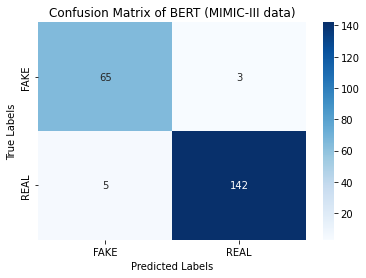

In [126]:
cm_bert_initial = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert_initial, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_bert_initial_mimic')

### Fine-tune hyperparameters<a class="anchor" id="7_12"></a>

In [34]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [35]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 61.86it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 59.21it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 56.97it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.60it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.06it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.71it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 56.46it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.22it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.83it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.93it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.76it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.42it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.68it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.91it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 49.10it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 52.05it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 52.13it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.14it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.00it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 56.60it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.49it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 57.02it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.22it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.25it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.17it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.10it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.04it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 642, validation data size: 0


Training  : 100%|███████████████████████████████████| 21/21 [00:03<00:00,  6.92it/s, loss=0.0534]


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [36]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.950 (+/-0.004) for {'epochs': 50, 'learning_rate': 2e-05}
0.955 (+/-0.012) for {'epochs': 50, 'learning_rate': 3e-05}
0.952 (+/-0.009) for {'epochs': 50, 'learning_rate': 1e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 2e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 75, 'learning_rate': 1e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 2e-05}
0.949 (+/-0.000) for {'epochs': 100, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9548286604361372 with params: {'epochs': 75, 'learning_rate': 1e-05}


In [33]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
# !nvidia-smi

'Tesla P100-PCIE-16GB'

In [136]:
#define a batch size
batch_size = 5
epochs = 75
learning_rate = 1e-1

In [137]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [138]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 75


100%|██████████| 129/129 [00:08<00:00, 15.88it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.60it/s]


Training Loss: 0.079 dev performance, p:0.851, r:0.955, f1:0.900
current best score is 0.900

 Epoch 2 / 75



100%|██████████| 129/129 [00:08<00:00, 16.05it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.12it/s]


Training Loss: 0.072 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 3 / 75



100%|██████████| 129/129 [00:08<00:00, 15.97it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.38it/s]


Training Loss: 0.077 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 4 / 75



100%|██████████| 129/129 [00:08<00:00, 15.86it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 72.18it/s]


Training Loss: 0.070 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 5 / 75



100%|██████████| 129/129 [00:08<00:00, 15.79it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 73.62it/s]


Training Loss: 0.062 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 6 / 75



100%|██████████| 129/129 [00:08<00:00, 15.76it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 68.95it/s]


Training Loss: 0.065 dev performance, p:0.853, r:0.970, f1:0.908
current best score is 0.908

 Epoch 7 / 75



100%|██████████| 129/129 [00:08<00:00, 15.62it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.42it/s]


Training Loss: 0.070 dev performance, p:0.849, r:0.939, f1:0.892

 Epoch 8 / 75



100%|██████████| 129/129 [00:08<00:00, 15.82it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.95it/s]


Training Loss: 0.064 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 9 / 75



100%|██████████| 129/129 [00:05<00:00, 25.35it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 110.45it/s]


Training Loss: 0.069 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 10 / 75



100%|██████████| 129/129 [00:04<00:00, 29.50it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 102.40it/s]


Training Loss: 0.062 dev performance, p:0.818, r:0.955, f1:0.881

 Epoch 11 / 75



100%|██████████| 129/129 [00:04<00:00, 29.38it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 110.15it/s]


Training Loss: 0.067 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 12 / 75



100%|██████████| 129/129 [00:04<00:00, 29.53it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 110.34it/s]


Training Loss: 0.075 dev performance, p:0.800, r:0.970, f1:0.877

 Epoch 13 / 75



100%|██████████| 129/129 [00:04<00:00, 26.26it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.74it/s]


Training Loss: 0.105 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 14 / 75



100%|██████████| 129/129 [00:04<00:00, 25.86it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.55it/s]


Training Loss: 0.101 dev performance, p:0.865, r:0.970, f1:0.914
current best score is 0.914

 Epoch 15 / 75



100%|██████████| 129/129 [00:07<00:00, 17.64it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 79.58it/s]


Training Loss: 0.114 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 16 / 75



100%|██████████| 129/129 [00:08<00:00, 15.85it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.00it/s]


Training Loss: 0.098 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 17 / 75



100%|██████████| 129/129 [00:08<00:00, 15.87it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.48it/s]


Training Loss: 0.089 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 18 / 75



100%|██████████| 129/129 [00:08<00:00, 15.86it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.68it/s]


Training Loss: 0.078 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 19 / 75



100%|██████████| 129/129 [00:08<00:00, 15.89it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.07it/s]


Training Loss: 0.071 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 20 / 75



100%|██████████| 129/129 [00:08<00:00, 15.88it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.65it/s]


Training Loss: 0.074 dev performance, p:0.861, r:0.939, f1:0.899

 Epoch 21 / 75



100%|██████████| 129/129 [00:08<00:00, 15.88it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.28it/s]


Training Loss: 0.093 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 22 / 75



100%|██████████| 129/129 [00:08<00:00, 15.94it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.35it/s]


Training Loss: 0.073 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 23 / 75



100%|██████████| 129/129 [00:08<00:00, 16.11it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.48it/s]


Training Loss: 0.066 dev performance, p:0.829, r:0.955, f1:0.887

 Epoch 24 / 75



100%|██████████| 129/129 [00:08<00:00, 15.93it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.23it/s]


Training Loss: 0.069 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 25 / 75



100%|██████████| 129/129 [00:08<00:00, 15.98it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.58it/s]


Training Loss: 0.064 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 26 / 75



100%|██████████| 129/129 [00:08<00:00, 15.78it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 70.34it/s]


Training Loss: 0.063 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 27 / 75



100%|██████████| 129/129 [00:08<00:00, 15.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 72.90it/s]


Training Loss: 0.062 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 28 / 75



100%|██████████| 129/129 [00:08<00:00, 15.73it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 72.57it/s]


Training Loss: 0.063 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 29 / 75



100%|██████████| 129/129 [00:08<00:00, 15.66it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 73.32it/s]


Training Loss: 0.060 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 30 / 75



100%|██████████| 129/129 [00:08<00:00, 15.82it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.48it/s]


Training Loss: 0.066 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 31 / 75



100%|██████████| 129/129 [00:08<00:00, 15.91it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.17it/s]


Training Loss: 0.064 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 32 / 75



100%|██████████| 129/129 [00:08<00:00, 15.93it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.07it/s]


Training Loss: 0.059 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 33 / 75



100%|██████████| 129/129 [00:08<00:00, 15.89it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.14it/s]


Training Loss: 0.062 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 34 / 75



100%|██████████| 129/129 [00:08<00:00, 15.92it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.56it/s]


Training Loss: 0.061 dev performance, p:0.812, r:0.985, f1:0.890

 Epoch 35 / 75



100%|██████████| 129/129 [00:08<00:00, 16.05it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.05it/s]


Training Loss: 0.071 dev performance, p:0.800, r:0.970, f1:0.877

 Epoch 36 / 75



100%|██████████| 129/129 [00:08<00:00, 15.90it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.28it/s]


Training Loss: 0.068 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 37 / 75



100%|██████████| 129/129 [00:08<00:00, 16.03it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.63it/s]


Training Loss: 0.079 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 38 / 75



100%|██████████| 129/129 [00:08<00:00, 16.06it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.23it/s]


Training Loss: 0.071 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 39 / 75



100%|██████████| 129/129 [00:08<00:00, 16.11it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.42it/s]


Training Loss: 0.067 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 40 / 75



100%|██████████| 129/129 [00:08<00:00, 16.03it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.93it/s]


Training Loss: 0.066 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 41 / 75



100%|██████████| 129/129 [00:08<00:00, 16.03it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.68it/s]


Training Loss: 0.072 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 42 / 75



100%|██████████| 129/129 [00:08<00:00, 16.04it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.30it/s]


Training Loss: 0.066 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 43 / 75



100%|██████████| 129/129 [00:08<00:00, 15.87it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.31it/s]


Training Loss: 0.071 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 44 / 75



100%|██████████| 129/129 [00:07<00:00, 16.13it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.22it/s]


Training Loss: 0.060 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 45 / 75



100%|██████████| 129/129 [00:08<00:00, 16.04it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.05it/s]


Training Loss: 0.075 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 46 / 75



100%|██████████| 129/129 [00:06<00:00, 19.79it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.09it/s]


Training Loss: 0.063 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 47 / 75



100%|██████████| 129/129 [00:05<00:00, 25.39it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.97it/s]


Training Loss: 0.065 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 48 / 75



100%|██████████| 129/129 [00:05<00:00, 25.40it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 107.71it/s]


Training Loss: 0.064 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 49 / 75



100%|██████████| 129/129 [00:04<00:00, 25.82it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.80it/s]


Training Loss: 0.069 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 50 / 75



100%|██████████| 129/129 [00:05<00:00, 25.41it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.81it/s]


Training Loss: 0.064 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 51 / 75



100%|██████████| 129/129 [00:05<00:00, 25.56it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.93it/s]


Training Loss: 0.088 dev performance, p:0.810, r:0.970, f1:0.883

 Epoch 52 / 75



100%|██████████| 129/129 [00:05<00:00, 25.38it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 107.71it/s]


Training Loss: 0.064 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 53 / 75



100%|██████████| 129/129 [00:04<00:00, 26.24it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.48it/s]


Training Loss: 0.068 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 54 / 75



100%|██████████| 129/129 [00:04<00:00, 27.41it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.47it/s]


Training Loss: 0.069 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 55 / 75



100%|██████████| 129/129 [00:04<00:00, 25.96it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.29it/s]


Training Loss: 0.063 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 56 / 75



100%|██████████| 129/129 [00:04<00:00, 26.49it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 105.82it/s]


Training Loss: 0.067 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 57 / 75



100%|██████████| 129/129 [00:05<00:00, 25.70it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.96it/s]


Training Loss: 0.075 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 58 / 75



100%|██████████| 129/129 [00:05<00:00, 25.45it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.38it/s]


Training Loss: 0.065 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 59 / 75



100%|██████████| 129/129 [00:04<00:00, 26.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.82it/s]


Training Loss: 0.068 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 60 / 75



100%|██████████| 129/129 [00:05<00:00, 25.44it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.70it/s]


Training Loss: 0.059 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 61 / 75



100%|██████████| 129/129 [00:04<00:00, 25.80it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.22it/s]


Training Loss: 0.064 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 62 / 75



100%|██████████| 129/129 [00:04<00:00, 25.90it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.91it/s]


Training Loss: 0.064 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 63 / 75



100%|██████████| 129/129 [00:05<00:00, 25.56it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.85it/s]


Training Loss: 0.061 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 64 / 75



100%|██████████| 129/129 [00:05<00:00, 25.41it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.17it/s]


Training Loss: 0.073 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 65 / 75



100%|██████████| 129/129 [00:04<00:00, 25.98it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.21it/s]


Training Loss: 0.061 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 66 / 75



100%|██████████| 129/129 [00:05<00:00, 25.50it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.52it/s]


Training Loss: 0.065 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 67 / 75



100%|██████████| 129/129 [00:04<00:00, 25.97it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.71it/s]


Training Loss: 0.062 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 68 / 75



100%|██████████| 129/129 [00:05<00:00, 25.49it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.64it/s]


Training Loss: 0.060 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 69 / 75



100%|██████████| 129/129 [00:04<00:00, 27.85it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.50it/s]


Training Loss: 0.065 dev performance, p:0.829, r:0.955, f1:0.887

 Epoch 70 / 75



100%|██████████| 129/129 [00:04<00:00, 29.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.93it/s]


Training Loss: 0.065 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 71 / 75



100%|██████████| 129/129 [00:04<00:00, 29.74it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.12it/s]



Training Loss: 0.061 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 72 / 75


100%|██████████| 129/129 [00:04<00:00, 29.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 107.17it/s]


Training Loss: 0.064 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 73 / 75



100%|██████████| 129/129 [00:04<00:00, 25.97it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.78it/s]


Training Loss: 0.063 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 74 / 75



100%|██████████| 129/129 [00:04<00:00, 25.98it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.57it/s]


Training Loss: 0.059 dev performance, p:0.829, r:0.955, f1:0.887

 Epoch 75 / 75



100%|██████████| 129/129 [00:05<00:00, 25.49it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.94it/s]


Training Loss: 0.061 dev performance, p:0.818, r:0.955, f1:0.881


In [139]:
model_file = 'bert_finetune_mimic.pt'
torch.save(best_model_state, model_file)

In [140]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bert_finetune_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the optimized BERT

In [141]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [142]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 43/43 [00:00<00:00, 108.14it/s]

{'precision': 0.9420289855072463, 'recall': 0.9558823529411765, 'f1': 0.9489051094890512}


In [143]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       147
           1       0.93      0.97      0.95        68

    accuracy                           0.97       215
   macro avg       0.96      0.97      0.96       215
weighted avg       0.97      0.97      0.97       215



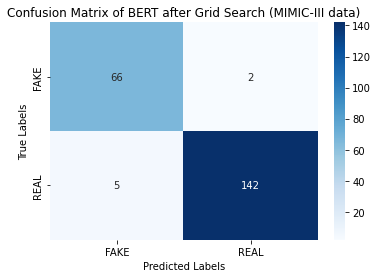

In [144]:
cm_bert_finetune = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert_finetune, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT after Grid Search (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BERT(grid search)_mimic')

## Classification algorithm 2: BlueBERT
### Train the BlueBERT

In [145]:
# bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
# import BERT-base pretrained model
bert_2 = AutoModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
# Load the BERT tokenizer
tokenizer_2 = BertTokenizerFast.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [146]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer_2.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [147]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [148]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [149]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert_2, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert_2 = bert_2 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert_2 to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert_2(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [150]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [151]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [152]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [55]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.71it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 132.52it/s]


Training Loss: 0.326 dev performance, p:0.913, r:0.636, f1:0.750
current best score is 0.750

 Epoch 2 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.41it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 155.12it/s]


Training Loss: 0.262 dev performance, p:0.882, r:0.909, f1:0.896
current best score is 0.896

 Epoch 3 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.68it/s]


Training Loss: 0.197 dev performance, p:0.851, r:0.955, f1:0.900
current best score is 0.900

 Epoch 4 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.34it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.24it/s]


Training Loss: 0.137 dev performance, p:0.877, r:0.970, f1:0.921
current best score is 0.921

 Epoch 5 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.33it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.28it/s]


Training Loss: 0.162 dev performance, p:0.881, r:0.894, f1:0.887

 Epoch 6 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.33it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 152.75it/s]


Training Loss: 0.151 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 7 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.52it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.77it/s]


Training Loss: 0.132 dev performance, p:0.889, r:0.970, f1:0.928
current best score is 0.928

 Epoch 8 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.07it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.24it/s]


Training Loss: 0.126 dev performance, p:0.886, r:0.939, f1:0.912

 Epoch 9 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.19it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.18it/s]


Training Loss: 0.138 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 10 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.14it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.07it/s]


Training Loss: 0.103 dev performance, p:0.886, r:0.939, f1:0.912

 Epoch 11 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.23it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.13it/s]


Training Loss: 0.099 dev performance, p:0.900, r:0.955, f1:0.926

 Epoch 12 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.25it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.50it/s]


Training Loss: 0.104 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 13 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 36.69it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 147.42it/s]


Training Loss: 0.147 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 14 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.90it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.36it/s]


Training Loss: 0.128 dev performance, p:0.886, r:0.939, f1:0.912

 Epoch 15 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.02it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.88it/s]


Training Loss: 0.119 dev performance, p:0.823, r:0.985, f1:0.897

 Epoch 16 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.24it/s]


Training Loss: 0.130 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 17 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.06it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.82it/s]


Training Loss: 0.117 dev performance, p:0.900, r:0.955, f1:0.926

 Epoch 18 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.12it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.51it/s]


Training Loss: 0.109 dev performance, p:0.900, r:0.955, f1:0.926

 Epoch 19 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.06it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.85it/s]


Training Loss: 0.116 dev performance, p:0.889, r:0.970, f1:0.928

 Epoch 20 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.03it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.62it/s]


Training Loss: 0.098 dev performance, p:0.863, r:0.955, f1:0.906


In [56]:
model_file = 'bluebert_initial_mimic.pt'
torch.save(best_model_state, model_file)

In [57]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bluebert_initial_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the BlueBERT

In [153]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [59]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.01it/s]

{'precision': 0.9558823529411765, 'recall': 0.9558823529411765, 'f1': 0.9558823529411765}


In [60]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       147
           1       0.93      0.96      0.94        68

    accuracy                           0.96       215
   macro avg       0.95      0.96      0.96       215
weighted avg       0.96      0.96      0.96       215



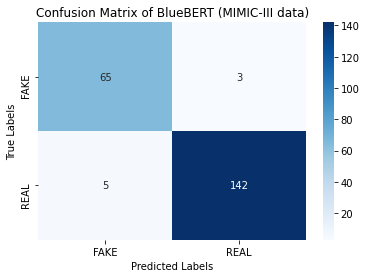

In [61]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT_mimic')

### Grid search of BlueBERT for optimization

In [62]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.46it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.13it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 49.34it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.58it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.28it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 47.49it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.64it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.83it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.26it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.36it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 47.15it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 46.63it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 43.93it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 45.47it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 49.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.50it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.81it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.43it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.35it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.35it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.42it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.10it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.65it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.29it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.20it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 642, validation data size: 0


Training  : 100%|███████████████████████████████████| 21/21 [00:03<00:00,  6.94it/s, loss=0.0534]


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [63]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.950 (+/-0.004) for {'epochs': 50, 'learning_rate': 2e-05}
0.955 (+/-0.012) for {'epochs': 50, 'learning_rate': 3e-05}
0.952 (+/-0.009) for {'epochs': 50, 'learning_rate': 1e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 2e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 75, 'learning_rate': 1e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 2e-05}
0.949 (+/-0.000) for {'epochs': 100, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9548286604361372 with params: {'epochs': 75, 'learning_rate': 1e-05}


In [163]:
#define a batch size
batch_size = 5
epochs = 100
learning_rate = 1e-1

In [164]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [165]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 100


100%|██████████| 129/129 [00:05<00:00, 24.94it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.64it/s]


Training Loss: 0.114 dev performance, p:0.851, r:0.955, f1:0.900


current best score is 0.900

 Epoch 2 / 100


100%|██████████| 129/129 [00:05<00:00, 25.63it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.07it/s]


Training Loss: 0.088 dev performance, p:0.875, r:0.955, f1:0.913


current best score is 0.913

 Epoch 3 / 100


100%|██████████| 129/129 [00:04<00:00, 29.64it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.62it/s]


Training Loss: 0.081 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 4 / 100



100%|██████████| 129/129 [00:04<00:00, 28.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.35it/s]


Training Loss: 0.073 dev performance, p:0.853, r:0.970, f1:0.908



 Epoch 5 / 100


100%|██████████| 129/129 [00:05<00:00, 25.79it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.21it/s]


Training Loss: 0.077 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 6 / 100



100%|██████████| 129/129 [00:04<00:00, 27.11it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.49it/s]


Training Loss: 0.074 dev performance, p:0.873, r:0.939, f1:0.905

 Epoch 7 / 100



100%|██████████| 129/129 [00:05<00:00, 25.21it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.81it/s]


Training Loss: 0.067 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 8 / 100



100%|██████████| 129/129 [00:05<00:00, 25.75it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 107.17it/s]


Training Loss: 0.076 dev performance, p:0.887, r:0.955, f1:0.920


current best score is 0.920

 Epoch 9 / 100


100%|██████████| 129/129 [00:05<00:00, 25.45it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.54it/s]


Training Loss: 0.073 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 10 / 100



100%|██████████| 129/129 [00:05<00:00, 25.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.42it/s]


Training Loss: 0.064 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 11 / 100



100%|██████████| 129/129 [00:05<00:00, 25.56it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.84it/s]


Training Loss: 0.062 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 12 / 100



100%|██████████| 129/129 [00:05<00:00, 25.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 109.49it/s]


Training Loss: 0.061 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 13 / 100



100%|██████████| 129/129 [00:05<00:00, 25.49it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.33it/s]


Training Loss: 0.061 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 14 / 100



100%|██████████| 129/129 [00:05<00:00, 25.76it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.43it/s]


Training Loss: 0.065 dev performance, p:0.875, r:0.955, f1:0.913

 Epoch 15 / 100



100%|██████████| 129/129 [00:05<00:00, 25.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.75it/s]


Training Loss: 0.061 dev performance, p:0.875, r:0.955, f1:0.913

 Epoch 16 / 100



100%|██████████| 129/129 [00:05<00:00, 25.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 108.54it/s]


Training Loss: 0.062 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 17 / 100



100%|██████████| 129/129 [00:05<00:00, 25.29it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 88.31it/s]


Training Loss: 0.063 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 18 / 100



100%|██████████| 129/129 [00:05<00:00, 25.30it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.61it/s]


Training Loss: 0.060 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 19 / 100



100%|██████████| 129/129 [00:05<00:00, 24.36it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 106.45it/s]


Training Loss: 0.063 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 20 / 100



100%|██████████| 129/129 [00:07<00:00, 18.10it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.36it/s]


Training Loss: 0.061 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 21 / 100



100%|██████████| 129/129 [00:08<00:00, 15.52it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 81.35it/s]


Training Loss: 0.061 dev performance, p:0.875, r:0.955, f1:0.913

 Epoch 22 / 100



100%|██████████| 129/129 [00:08<00:00, 15.44it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 81.87it/s]


Training Loss: 0.062 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 23 / 100



100%|██████████| 129/129 [00:08<00:00, 15.51it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.35it/s]


Training Loss: 0.062 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 24 / 100



100%|██████████| 129/129 [00:08<00:00, 15.49it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.17it/s]


Training Loss: 0.061 dev performance, p:0.844, r:0.985, f1:0.909

 Epoch 25 / 100



100%|██████████| 129/129 [00:08<00:00, 15.53it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.59it/s]


Training Loss: 0.061 dev performance, p:0.875, r:0.955, f1:0.913

 Epoch 26 / 100



100%|██████████| 129/129 [00:08<00:00, 15.50it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.22it/s]


Training Loss: 0.071 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 27 / 100



100%|██████████| 129/129 [00:08<00:00, 15.50it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.37it/s]


Training Loss: 0.060 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 28 / 100



100%|██████████| 129/129 [00:08<00:00, 15.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.91it/s]


Training Loss: 0.059 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 29 / 100



100%|██████████| 129/129 [00:08<00:00, 15.51it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.87it/s]



Training Loss: 0.063 dev performance, p:0.873, r:0.939, f1:0.905

 Epoch 30 / 100


100%|██████████| 129/129 [00:08<00:00, 15.41it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.33it/s]


Training Loss: 0.063 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 31 / 100



100%|██████████| 129/129 [00:08<00:00, 15.54it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.19it/s]


Training Loss: 0.060 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 32 / 100



100%|██████████| 129/129 [00:08<00:00, 15.45it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.33it/s]



Training Loss: 0.058 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 33 / 100


100%|██████████| 129/129 [00:08<00:00, 15.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.36it/s]


Training Loss: 0.066 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 34 / 100



100%|██████████| 129/129 [00:08<00:00, 15.47it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.38it/s]


Training Loss: 0.061 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 35 / 100



100%|██████████| 129/129 [00:08<00:00, 15.53it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.22it/s]


Training Loss: 0.061 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 36 / 100



100%|██████████| 129/129 [00:08<00:00, 15.48it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 81.55it/s]


Training Loss: 0.061 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 37 / 100



100%|██████████| 129/129 [00:08<00:00, 15.54it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.03it/s]


Training Loss: 0.071 dev performance, p:0.844, r:0.985, f1:0.909

 Epoch 38 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.64it/s]


Training Loss: 0.085 dev performance, p:0.827, r:0.939, f1:0.879

 Epoch 39 / 100



100%|██████████| 129/129 [00:08<00:00, 15.57it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.48it/s]


Training Loss: 0.073 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 40 / 100



100%|██████████| 129/129 [00:08<00:00, 15.51it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.89it/s]


Training Loss: 0.071 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 41 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.16it/s]


Training Loss: 0.062 dev performance, p:0.844, r:0.985, f1:0.909

 Epoch 42 / 100



100%|██████████| 129/129 [00:08<00:00, 15.54it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.41it/s]


Training Loss: 0.064 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 43 / 100



100%|██████████| 129/129 [00:08<00:00, 15.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.79it/s]


Training Loss: 0.063 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 44 / 100



100%|██████████| 129/129 [00:08<00:00, 15.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.61it/s]


Training Loss: 0.061 dev performance, p:0.831, r:0.970, f1:0.895



 Epoch 45 / 100


100%|██████████| 129/129 [00:08<00:00, 15.54it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.42it/s]


Training Loss: 0.063 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 46 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.23it/s]


Training Loss: 0.069 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 47 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.12it/s]


Training Loss: 0.061 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 48 / 100



100%|██████████| 129/129 [00:08<00:00, 15.57it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.04it/s]


Training Loss: 0.067 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 49 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 80.54it/s]



Training Loss: 0.064 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 50 / 100


100%|██████████| 129/129 [00:08<00:00, 15.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.58it/s]


Training Loss: 0.076 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 51 / 100



100%|██████████| 129/129 [00:08<00:00, 15.52it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 80.91it/s]


Training Loss: 0.068 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 52 / 100



100%|██████████| 129/129 [00:08<00:00, 15.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.38it/s]


Training Loss: 0.064 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 53 / 100



100%|██████████| 129/129 [00:08<00:00, 15.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.07it/s]


Training Loss: 0.070 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 54 / 100



100%|██████████| 129/129 [00:08<00:00, 15.68it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 80.67it/s]


Training Loss: 0.067 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 55 / 100



100%|██████████| 129/129 [00:08<00:00, 15.57it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.26it/s]


Training Loss: 0.063 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 56 / 100



100%|██████████| 129/129 [00:08<00:00, 15.62it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.30it/s]


Training Loss: 0.066 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 57 / 100



100%|██████████| 129/129 [00:08<00:00, 15.63it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.81it/s]


Training Loss: 0.061 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 58 / 100



100%|██████████| 129/129 [00:08<00:00, 15.64it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.75it/s]


Training Loss: 0.068 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 59 / 100



100%|██████████| 129/129 [00:08<00:00, 15.61it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.91it/s]



Training Loss: 0.083 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 60 / 100


100%|██████████| 129/129 [00:08<00:00, 15.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.47it/s]


Training Loss: 0.082 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 61 / 100



100%|██████████| 129/129 [00:08<00:00, 15.47it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.71it/s]


Training Loss: 0.099 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 62 / 100



100%|██████████| 129/129 [00:08<00:00, 15.59it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.31it/s]


Training Loss: 0.086 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 63 / 100



100%|██████████| 129/129 [00:08<00:00, 15.59it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 89.38it/s]


Training Loss: 0.089 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 64 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.07it/s]


Training Loss: 0.067 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 65 / 100



100%|██████████| 129/129 [00:08<00:00, 15.51it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.00it/s]


Training Loss: 0.066 dev performance, p:0.855, r:0.985, f1:0.915

 Epoch 66 / 100



100%|██████████| 129/129 [00:08<00:00, 15.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.05it/s]


Training Loss: 0.064 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 67 / 100



100%|██████████| 129/129 [00:08<00:00, 15.61it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.21it/s]


Training Loss: 0.064 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 68 / 100



100%|██████████| 129/129 [00:08<00:00, 15.56it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.80it/s]


Training Loss: 0.073 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 69 / 100



100%|██████████| 129/129 [00:08<00:00, 15.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.46it/s]


Training Loss: 0.066 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 70 / 100



100%|██████████| 129/129 [00:08<00:00, 15.64it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.97it/s]


Training Loss: 0.065 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 71 / 100



100%|██████████| 129/129 [00:08<00:00, 15.68it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.89it/s]


Training Loss: 0.061 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 72 / 100



100%|██████████| 129/129 [00:08<00:00, 15.63it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.50it/s]


Training Loss: 0.064 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 73 / 100



100%|██████████| 129/129 [00:08<00:00, 15.48it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.81it/s]


Training Loss: 0.062 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 74 / 100



100%|██████████| 129/129 [00:08<00:00, 15.64it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 87.18it/s]


Training Loss: 0.061 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 75 / 100



100%|██████████| 129/129 [00:08<00:00, 15.66it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.97it/s]


Training Loss: 0.064 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 76 / 100



100%|██████████| 129/129 [00:08<00:00, 15.61it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.36it/s]


Training Loss: 0.061 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 77 / 100



100%|██████████| 129/129 [00:08<00:00, 15.53it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 89.89it/s]


Training Loss: 0.059 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 78 / 100



100%|██████████| 129/129 [00:08<00:00, 15.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.54it/s]


Training Loss: 0.071 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 79 / 100



100%|██████████| 129/129 [00:08<00:00, 15.68it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.62it/s]


Training Loss: 0.062 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 80 / 100



100%|██████████| 129/129 [00:08<00:00, 15.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 83.33it/s]


Training Loss: 0.062 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 81 / 100



100%|██████████| 129/129 [00:08<00:00, 15.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.80it/s]


Training Loss: 0.061 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 82 / 100



100%|██████████| 129/129 [00:08<00:00, 15.68it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 85.91it/s]


Training Loss: 0.069 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 83 / 100



100%|██████████| 129/129 [00:08<00:00, 15.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.79it/s]


Training Loss: 0.065 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 84 / 100



100%|██████████| 129/129 [00:08<00:00, 15.57it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 84.43it/s]


Training Loss: 0.063 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 85 / 100



100%|██████████| 129/129 [00:08<00:00, 15.59it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 82.20it/s]


Training Loss: 0.065 dev performance, p:0.844, r:0.985, f1:0.909

 Epoch 86 / 100



100%|██████████| 129/129 [00:08<00:00, 15.61it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 81.13it/s]


Training Loss: 0.063 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 87 / 100



100%|██████████| 129/129 [00:08<00:00, 15.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 86.81it/s]


Training Loss: 0.063 dev performance, p:0.855, r:0.985, f1:0.915

 Epoch 88 / 100



100%|██████████| 129/129 [00:10<00:00, 12.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 65.41it/s]


Training Loss: 0.059 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 89 / 100



100%|██████████| 129/129 [00:12<00:00, 10.58it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 67.04it/s]


Training Loss: 0.061 dev performance, p:0.831, r:0.970, f1:0.895

 Epoch 90 / 100



100%|██████████| 129/129 [00:12<00:00, 10.57it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 67.41it/s]


Training Loss: 0.065 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 91 / 100



100%|██████████| 129/129 [00:12<00:00, 10.60it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 67.85it/s]


Training Loss: 0.062 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 92 / 100



100%|██████████| 129/129 [00:12<00:00, 10.65it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 70.03it/s]


Training Loss: 0.075 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 93 / 100



100%|██████████| 129/129 [00:12<00:00, 10.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 64.07it/s]


Training Loss: 0.069 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 94 / 100



100%|██████████| 129/129 [00:12<00:00, 10.53it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 61.49it/s]


Training Loss: 0.066 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 95 / 100



100%|██████████| 129/129 [00:12<00:00, 10.59it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 66.51it/s]


Training Loss: 0.062 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 96 / 100



100%|██████████| 129/129 [00:12<00:00, 10.57it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 62.39it/s]


Training Loss: 0.066 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 97 / 100



100%|██████████| 129/129 [00:12<00:00, 10.61it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 70.12it/s]


Training Loss: 0.062 dev performance, p:0.875, r:0.955, f1:0.913

 Epoch 98 / 100



100%|██████████| 129/129 [00:12<00:00, 10.62it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 67.53it/s]


Training Loss: 0.063 dev performance, p:0.865, r:0.970, f1:0.914

 Epoch 99 / 100



100%|██████████| 129/129 [00:12<00:00, 10.49it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 58.96it/s]


Training Loss: 0.064 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 100 / 100



100%|██████████| 129/129 [00:12<00:00, 10.55it/s]

evaluating...



100%|██████████| 43/43 [00:00<00:00, 56.93it/s]


Training Loss: 0.060 dev performance, p:0.853, r:0.970, f1:0.908


In [166]:
model_file = 'bluebert_gridsearch_mimic.pt'
torch.save(best_model_state, model_file)

In [167]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bluebert_gridsearch_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the optimized BlueBERT

In [168]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [169]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 43/43 [00:00<00:00, 75.28it/s]

{'precision': 0.918918918918919, 'recall': 1.0, 'f1': 0.9577464788732395}


In [170]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       147
           1       0.93      1.00      0.96        68

    accuracy                           0.98       215
   macro avg       0.97      0.98      0.97       215
weighted avg       0.98      0.98      0.98       215



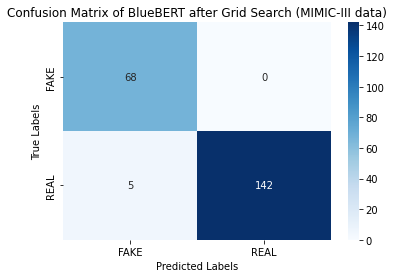

In [171]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT after Grid Search (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT(grid search)_mimic')